**Processing gsets and evaluating KL**

In [477]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx
import numba as nb
from sklearn.manifold import SpectralEmbedding
from tqdm import tqdm
from sklearn.cluster import SpectralClustering
import seaborn as sns

from ABCA7lof2.geneclusters import evaluate_cut, get_scores, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite, plot_component, plot_edges, plot_nodes, group, compute_groupped_matrix, get_scores, find_similar_clusters, get_representative_name_per_cluster, get_kernighan_lin_clusters, get_gene_pathway_matrix, compute_groupped_matrix, get_full_matrix_from_bipartite

#### Saving the gsets

In [ ]:
# save the gsets
p1 = np.load('./raw_data/genesets/WikiPathways_2019_Human.npy', allow_pickle=True).item()
res = {**p1}
np.save('./processed_data/genesets/all_paths.npy', res)
pd.DataFrame.from_dict(res, orient='index').to_csv('./processed_data/genesets/all_paths.csv')

In [40]:
p1 = np.load('./raw_data/genesets/GO_Biological_Process_2023.npy', allow_pickle=True).item()


#### functions

In [690]:
@nb.njit()
def compute_jaccard(arr1, arr2):
    outer = arr1-arr2
    i_outer = np.sum(outer>0)
    outer_sum = np.sum(np.abs(outer))
    shared = np.sum(arr1)-i_outer
    jaccard = shared/(outer_sum+shared)
    return jaccard

@nb.njit(parallel=True)
def compute_all_jaccard(mat_array):
    N = mat_array.shape[0]
    out = np.empty(shape=(N,N))
    for i in nb.prange(N):
        for j in nb.prange(N):
            out[i,j] = compute_jaccard(mat_array[i], mat_array[j])
    return out

@nb.njit()
def get_rand_index(x, y):
    a=0
    b=0
    c=0
    d=0
    for i in range(len(x)):
        for j in range(len(x)):
            if (x[i]==x[j]) & (y[i]==y[j]):
                a+=1
            elif (x[i]!=x[j]) & (y[i]!=y[j]):
                b+=1
            elif (x[i]!=x[j]) & (y[i]==y[j]):
                c+=1
            elif (x[i]==x[j]) & (y[i]!=y[j]):
                d+=1
    R = (a+b)/(a+b+c+d)
    return R


def get_spectral_partition(labels_sp, full_mat, n, c_names):
    embedding = SpectralEmbedding(n_components=1)
    X_transformed = embedding.fit_transform(full_mat)

    temp = (np.argsort(X_transformed.ravel()))
    N = len(temp)
    middle = int(N/2)
    labels_sp[temp[:middle]]=c_names[(n)]
    labels_sp[temp[middle:]]=c_names[(n+1)]
    return labels_sp

def get_LP(full_mat):
    LP = full_mat*-1
    np.fill_diagonal(LP, np.sum(full_mat, axis=1))
    return LP

def get_spectral_partition(labels_sp, LP, i, index):
    eigvals, eigvect = np.linalg.eig(LP)
    v2 = eigvect[:,np.argsort(eigvals)[1]]
    temp = (np.argsort(v2))
    N = len(temp)
    middle = int(N/2)
    x = labels_sp[0][index]

    x[temp[middle:]]=1
    x[temp[:middle]]=-1
    labels_sp[i][index] = x
    #return labels_sp
    

import numba as nb
@nb.njit()
def compute_jaccard(arr1, arr2):
    outer = arr1-arr2
    i_outer = np.sum(outer>0)
    outer_sum = np.sum(np.abs(outer))
    shared = np.sum(arr1)-i_outer
    jaccard = shared/(outer_sum+shared)
    return jaccard

@nb.njit(parallel=True)
def compute_all_jaccard(mat_array):
    N = mat_array.shape[0]
    out = np.empty(shape=(N,N))
    for i in nb.prange(N):
        for j in nb.prange(N):
            out[i,j] = compute_jaccard(mat_array[i], mat_array[j])
    return out
@nb.njit(parallel=True)
def compute_jaccard_all_clust(arr1, arr2):
    N = len(np.unique(arr1))
    out = np.empty(shape=(N,N))
    for i in nb.prange(N):
        for j in nb.prange(N):
            i_0 = (arr1==i)#.astype(int)
            j_0 = (arr2==j)#.astype(int)
            out[i,j] = compute_jaccard(i_0, j_0)
    return out


#### Subset matrix of interest

In [14]:
# subset matrix
mat = get_gene_pathway_matrix('./processed_data/genesets/all_paths.npy')
leading_edge = './processed_data/for_plotting/leading_edge_0825Ex.csv'
leading_edge = pd.read_csv(leading_edge, index_col=0)
S = set(leading_edge['gene'])

col_index = np.where([x in S for x in mat.columns])[0]
mat_sub = mat.iloc[:,col_index]

path_index = (np.sum(mat_sub, axis=1)>4)
mat_sub = mat_sub.loc[path_index]
mat_sub = mat_sub.loc[:,np.sum(mat_sub, axis=0)>0]

#### Plot Jaccard indices pre clustering

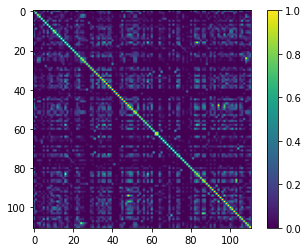

In [17]:
# get pathway gene matrix
mat_array = np.array(mat_sub)
out = compute_all_jaccard(mat_array)

embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(out)

plt.imshow(out, cmap='viridis')
plt.colorbar()

### benchmarking KL

In [579]:
# run many KL iterations

C = 0
KL_modified = True
random_labels = True
unweighted = True

N=1000
loss = np.empty(N)
clusters = np.empty((N,np.sum(mat_sub.shape)))

for i in tqdm(range(N)):
    frame, loss_temp = get_kernighan_lin_clusters(None, 50, C, KL_modified, random_labels, unweighted, seed=i, no_progress=True, mat=mat_sub)
    frame.columns = ['cluster', 'description', 'is_gene']
    clusters[i] = np.array(frame['cluster'])
    loss[i] = loss_temp

100%|██████████| 1000/1000 [05:32<00:00,  3.01it/s]


In [660]:
N=1000

In [661]:
# compute rand index for all pairwise KL assignments
all_rands = np.empty((N, N))
for i in tqdm(range(N)):
    for j in range(N):
        all_rands[i, j] = get_rand_index(clusters[i], clusters[j])

100%|██████████| 1000/1000 [02:39<00:00,  6.27it/s]


### random assignment of labels

In [675]:
clust_uniform=np.zeros_like(clusters)
loss_uniform=np.zeros_like(loss_kl)
for i in range(1000):
    x = np.random.randint(low=0, high=7, size=len(clusters[0]))
    clust_uniform[i] = x
    loss_uniform[i] = evaluate_cut(np.ascontiguousarray(mat_sub.values.T), x, 0)

In [686]:
# compute rand index for all pairwise KL assignments
all_rands_uniform = np.empty((N, N))
for i in tqdm(range(N)):
    for j in range(N):
        all_rands_uniform[i, j] = get_rand_index(clust_uniform[i], clust_uniform[j])

100%|██████████| 1000/1000 [02:41<00:00,  6.20it/s]


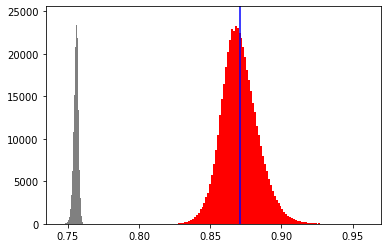

In [742]:
# plot loss and rand index
rands_kl = all_rands[np.tril_indices_from(all_rands, k=-1)]
rands_perm_kl = all_rands_uniform[np.tril_indices_from(all_rands_uniform, k=-1)]

plt.hist(rands_kl, bins=100, color='red')
plt.axvline(x = np.mean(rands_kl), color = 'b', label = 'axvline - full height')

plt.hist(rands_perm_kl, bins=100, color='grey')
None

plt.savefig('./pdf_figures/kl_rand_index.pdf')

In [741]:
np.mean(rands_kl)

0.8707512843912337

### spectral bissection

In [677]:
# compute laplacian matrix
full_mat = np.zeros((np.sum(mat_sub.shape), np.sum(mat_sub.shape)))
full_mat[mat_sub.shape[1]:][:,:mat_sub.shape[1]] = mat_sub
full_mat[:mat_sub.shape[1]][:,mat_sub.shape[1]:]=mat_sub.T

i=0
nclust = 8
it = int(np.log2(nclust))
labels_sp = np.zeros((nclust,full_mat.shape[0]))

for x in range(it):
    grps = np.unique(labels_sp, axis=1)
    index = [[np.unique(labels_sp[:,x]==grps[:,y])[0] for x in range(labels_sp.shape[1])] for y in range(grps.shape[1])]
    for j in range(len(index)):
        get_spectral_partition(labels_sp,  get_LP(full_mat[index[j]][:,index[j]]), i, index[j])
        i+=1
labels_sp = [np.argwhere(np.sum(np.unique(labels_sp, axis=1)-labels_sp[:,x].reshape(-1,1)==0, axis=0)==nclust)[0][0] for x in range(labels_sp.shape[1])] 

In [678]:
loss_sp = evaluate_cut(np.ascontiguousarray(mat_sub.values.T), labels_sp, 0)

### spectral clustering

In [697]:
loss_sc=np.empty(1000)
labs_sc = np.zeros_like(clusters)
for i in (range(1000)): 
    sc = SpectralClustering(8, assign_labels='discretize', random_state=i).fit(full_mat)
    loss_sc[i]=evaluate_cut(np.ascontiguousarray(mat_sub.values.T), sc.labels_, 0)
    labs_sc[i] = sc.labels_

/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/cluster/_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/cluster/_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/cluster/_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/cluster/_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinit

### plot benchmarks

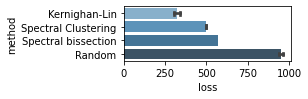

In [739]:
# plot loss by method for cluster size 8

df = pd.DataFrame(np.concatenate((loss_kl, loss_sc, np.array([loss_sp]), loss_uniform)))
df['method'] = np.concatenate((np.repeat('Kernighan-Lin', len(loss_kl)), np.repeat('Spectral Clustering', len(loss_sc)), ['Spectral bissection'], np.repeat('Random', len(loss_uniform))))
df.columns = ['loss', 'method']

plt.figure(figsize=(3,1))

sns.barplot(data=df, x="loss", y="method", estimator=np.mean, ci='sd', capsize=.2, color='lightblue', palette = "Blues_d")
plt.savefig('./pdf_figures/losses.pdf')

In [568]:
# plot loss by method for a range of sizes

/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


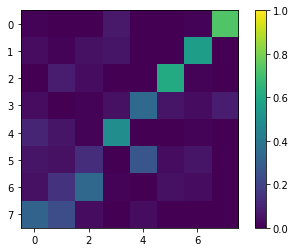

In [716]:
# plot jaccard for one example of each method

temp = compute_jaccard_all_clust(clusters[0], clusters[90])
T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(temp[o][:,o], cmap='viridis', vmax=1, vmin=0)
plt.colorbar()

plt.savefig('./pdf_figures/KL_jaccard.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


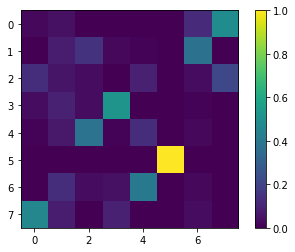

In [719]:
# plot jaccard for one example of each method

temp = compute_jaccard_all_clust(clusters[0], clusters[45])
T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(temp[o][:,o], cmap='viridis', vmax=1, vmin=0)
plt.colorbar()

plt.savefig('./pdf_figures/KL_jaccard1.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


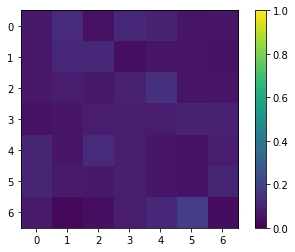

In [720]:
# plot jaccard for one example of each method

temp = compute_jaccard_all_clust(clust_uniform[0], clust_uniform[1])
T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(temp, cmap='viridis', vmax=1, vmin=0)
plt.colorbar()

plt.savefig('./pdf_figures/uniform_jaccard.pdf')

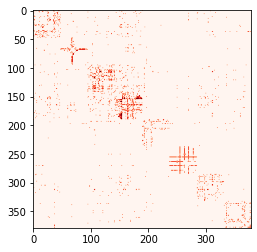

In [751]:
# plot adjacency matrix for one example of each method
plt.imshow(full_mat[np.argsort(clusters[0])][:,np.argsort(clusters[0])], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_KL_cluster.pdf')

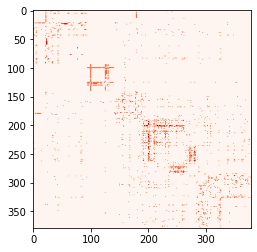

In [753]:
# plot adjacency matrix for one example of each method
plt.imshow(full_mat[np.argsort(labels_sp)][:,np.argsort(labels_sp)], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_SP_cluster.pdf')

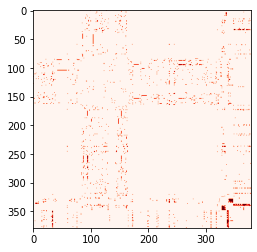

In [754]:
# plot adjacency matrix for one example of each method
plt.imshow(full_mat[np.argsort(labs_sc[0])][:,np.argsort(labs_sc[0])], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_SC_cluster.pdf')

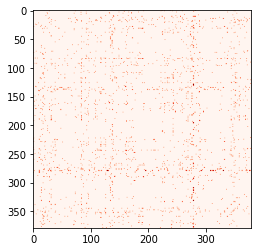

In [755]:
plt.imshow(full_mat[np.argsort(clust_uniform[0])][:,np.argsort(clust_uniform[0])], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_uniform_cluster.pdf')

### plot losses for diff cluster sizes

### show the jaccard for each method, then plot losses etc, losses by diff cluster sizes, rand for random initiations, consistency across different cluster sizes with rand

In [464]:
np.unique(sc.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([326,   2,   5,   2,   2,   3,   8,  31]))

In [459]:
# below is scrap

In [466]:
all_rands

array([[1.        , 0.87521669, 0.8844898 , ..., 0.87518884, 0.87566224,
        0.8840721 ],
       [0.87521669, 1.        , 0.86399426, ..., 0.86137663, 0.89075542,
        0.88151015],
       [0.8844898 , 0.86399426, 1.        , ..., 0.86185003, 0.86315885,
        0.89328952],
       ...,
       [0.87518884, 0.86137663, 0.86185003, ..., 1.        , 0.88251265,
        0.87972793],
       [0.87566224, 0.89075542, 0.86315885, ..., 0.88251265, 1.        ,
        0.8865505 ],
       [0.8840721 , 0.88151015, 0.89328952, ..., 0.87972793, 0.8865505 ,
        1.        ]])

In [211]:
get_LP

<function __main__.get_LP(full_mat)>

In [ ]:
get_spectral_partition(labels_sp, get_LP(full_mat), 0)

In [213]:
labels_sp[0][index][temp[middle:]]=11

In [219]:
float(11)

11.0

In [220]:
labels_sp[0][index]=1

In [222]:
labels_sp[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [144]:
full_mat[labels_sp[0]==1][[labels_sp[0]==1]]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 190 but corresponding boolean dimension is 1

In [130]:
get_spectral_partition

<function __main__.get_spectral_partition(labels_sp, LP, i, c_names)>

In [ ]:
labels_sp = np.empty((np.sum(mat_sub.shape)))


In [127]:
labels_sp = np.empty((np.sum(mat_sub.shape)))
n = 0
c_names = np.arange(50)

labels_sp = get_spectral_partition(labels_sp, full_mat, n, c_names)
test = 60
while test>0:
    for lab in np.unique(labels_sp):
        print(lab)
        index = labels_sp==lab
        n+=2
        labels_sp[index] = get_spectral_partition(labels_sp[index], full_mat[index][:,index], n, c_names)
        
        test = np.sum(np.unique(labels_sp, return_counts=True)[1]>50)

0.0


IndexError: index 221 is out of bounds for axis 0 with size 189

In [113]:
v2 = eigvect[:,1]

In [124]:
np.argsort(v2)

array([135, 149, 132, 133, 130, 138, 139, 140, 136, 142, 143, 144, 145,
       146, 141, 137, 147, 148, 134,  53,  50,  51,  52, 221,  55,  56,
        49,  54,  48, 263,  18,  19,  20,  21,  17,  15,  46,  47, 220,
        16, 230, 229, 163,  97,  36,   3,  28, 241, 169, 170, 153, 131,
       315, 373, 366, 290, 337, 313, 365, 352, 362, 316, 321, 350, 348,
       119, 282, 374, 273, 285, 303, 301, 332, 318, 307, 281, 369, 326,
       304, 268, 317, 360, 328,  14,  37, 196,  11, 200, 120, 236,  22,
       171,  71, 127, 116, 223, 201, 117, 105,  26, 189, 186, 190, 184,
        94,  95, 108, 258,  96,  27,  41,  58, 251, 214, 222, 207, 252,
       204,  59,  25, 216, 168, 256, 115, 103,   0, 242, 266,  29,  91,
        89, 118, 121, 129, 209,  61, 226, 368, 367,   1, 202, 250,  68,
       278,  74, 297, 238, 234, 185, 235, 262, 257, 231, 156,  34, 161,
        32,  33,  78, 128, 249,  40, 159, 158, 157,  67, 213,  88,  73,
       206, 267, 264,  31,  30, 246,  69, 254,  70, 160, 255,   

In [122]:
np.sum(eigvect[:,np.argsort(eigvals)[1]]>0)

273

In [110]:
eigvals[1]

(43.34126109537155+0j)

In [109]:
eigvals[9]

(26.82328568169773+0j)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [63]:
labels_sp = np.empty((np.sum(mat_sub.shape)))
n = 0
labels_sp = get_spectral_partition(labels_sp, full_mat, n, c_names)
test = 60
while test>0:
    for lab in np.unique(labels_sp):
        print(lab)
        index = labels_sp==lab
        n+=2
        labels_sp[index] = get_spectral_partition(labels_sp[index], full_mat[index][:,index], n, c_names)
        
        test = np.sum(np.unique(labels_sp, return_counts=True)[1]>50)

0.0
1.0
2.0
3.0
4.0
5.0


/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [58]:
evaluate_cut(np.ascontiguousarray(mat_sub.values.T), labels_sp, 0)

987

In [64]:
evaluate_cut(np.ascontiguousarray(mat_sub.values.T), labels_sp, 0)

1024

In [39]:
# spectral partitioning 


c_names = np.arange(50)
labels_sp = np.zeros((np.sum(mat_sub.shape)))
n =0
labels_sp = get_spectral_partition(labels_sp, full_mat, n, c_names)

In [40]:
labels_sp

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 1.

In [383]:
index = labels_sp==0
get_spectral_partition(labels_sp[index], full_mat[index][:,index], n, c_names)

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0.])

0.0
1.0
2.0
3.0
4.0
5.0


In [47]:
np.unique(labels_sp, return_counts=True)

(array([ 6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 array([47, 47, 47, 48, 47, 48, 47, 48]))

In [403]:
evaluate_cut(np.ascontiguousarray(mat_sub.values.T), labels_sp, 0)

999

In [395]:
evaluate_cut(np.ascontiguousarray(mat_sub.values.T), labels_sp, 0)

1021

In [397]:
evaluate_cut(np.ascontiguousarray(mat_sub.values.T), clusters[0], 0)

315

In [390]:
get_rand_index(clusters[0], labels_sp)

0.8003634059913256

In [399]:
np.random.permutation(np.unique(labels_sp, return_counts=True)[0])

array([ 9.,  6., 11.,  7., 10., 13.,  8., 12.])

In [321]:
test = np.unique(labels_sp, return_counts=True)[1][0]

In [322]:
test

189

In [317]:
test = np.unique(labels_sp, return_counts=True)[1][0]

In [318]:
test

94

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [198]:
 temp[:middle]

array([187, 194, 192, 188, 182, 193, 183, 195, 181, 185, 189, 190, 186,
       184, 261, 177, 175, 178, 172, 180, 179, 174, 176, 173,  87, 262,
       191, 211, 259, 341, 306, 324, 318, 303, 282, 317, 350, 351, 284,
       355, 365, 328, 321, 301, 354, 371, 316, 362,  40, 307, 326, 101,
       268, 313, 369, 332, 304, 342, 364, 102, 214, 100, 373, 166, 116,
       277, 374, 352, 337, 117, 208, 291,  93, 280, 298, 378, 249, 104,
       113, 368, 106,  99, 290,  92, 360, 237, 151, 359, 217, 297, 281,
       158, 159, 157, 285, 165, 164, 278, 275, 273,  90, 171,  60,  12,
       236, 305, 315,  79,  77, 366, 358, 109, 243,   6, 269, 319, 314,
       238, 375, 323, 377, 348, 206, 279, 160, 320, 271, 312, 333, 267,
       246, 255, 254,  62, 276, 264, 367, 300, 370, 270, 322, 293, 339,
       329, 357, 308, 340, 227, 224, 150, 225, 361, 114, 122, 292, 376,
       125, 205, 295, 299,  14, 327, 372, 349, 338, 343, 330, 274, 296,
       331,  88, 219, 123, 272, 309, 199, 356, 363, 283, 226, 30

In [ ]:
take your vertices
Spectral embedding
sort them
take the left half and recurse
take the right half and recurse

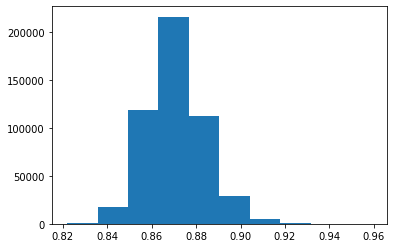

In [147]:
plt.hist(all_rands[np.triu_indices(n=all_rands.shape[0], k=1)])
None

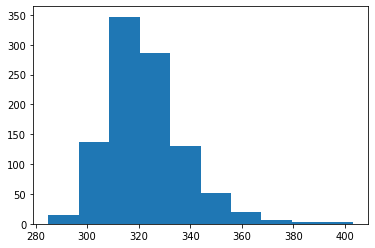

In [150]:
plt.hist(loss)
None

In [154]:
np.sum(np.sum(mat_sub))

1110

/home/gridsan/djuna/.local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


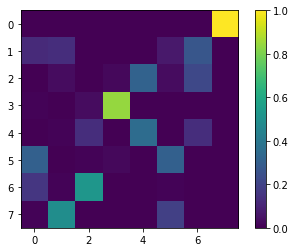

In [64]:

import numba as nb
@nb.njit()
def compute_jaccard(arr1, arr2):
    outer = arr1-arr2
    i_outer = np.sum(outer>0)
    outer_sum = np.sum(np.abs(outer))
    shared = np.sum(arr1)-i_outer
    jaccard = shared/(outer_sum+shared)
    return jaccard

@nb.njit(parallel=True)
def compute_all_jaccard(mat_array):
    N = mat_array.shape[0]
    out = np.empty(shape=(N,N))
    for i in nb.prange(N):
        for j in nb.prange(N):
            out[i,j] = compute_jaccard(mat_array[i], mat_array[j])
    return out
@nb.njit(parallel=True)
def compute_jaccard_all_clust(arr1, arr2):
    N = len(np.unique(arr1))
    out = np.empty(shape=(N,N))
    for i in nb.prange(N):
        for j in nb.prange(N):
            i_0 = (arr1==i)#.astype(int)
            j_0 = (arr2==j)#.astype(int)
            out[i,j] = compute_jaccard(i_0, j_0)
    return out


/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


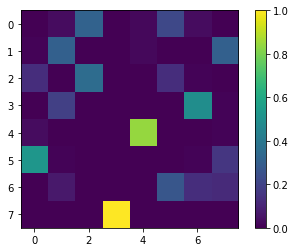

In [77]:
temp = compute_jaccard_all_clust(clusters[5], clusters[1])
T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(temp, cmap='viridis', vmax=1, vmin=0)
plt.colorbar()

/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


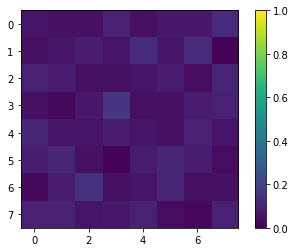

In [78]:
temp = compute_jaccard_all_clust(np.random.permutation(clusters[1]), clusters[5])

T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(T[o][:,o], cmap='viridis', vmax=1, vmin=0)
plt.colorbar()

100%|██████████| 1000/1000 [02:37<00:00,  6.35it/s]


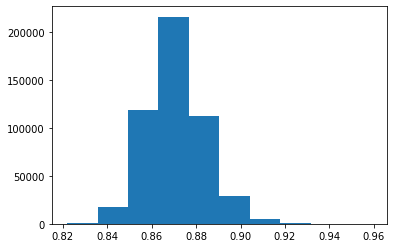

(array([9.83000e+02, 1.71850e+04, 1.19099e+05, 2.16192e+05, 1.12127e+05,
        2.86790e+04, 4.64600e+03, 5.20000e+02, 6.20000e+01, 7.00000e+00]),
 array([0.82202853, 0.83571821, 0.8494079 , 0.86309758, 0.87678727,
        0.89047695, 0.90416664, 0.91785632, 0.93154601, 0.94523569,
        0.95892538]),
 <BarContainer object of 10 artists>)

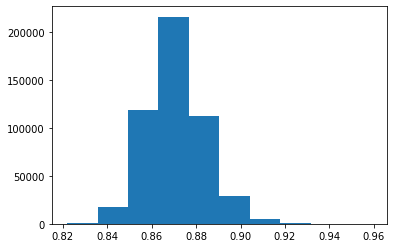

In [142]:
(((1000*1000)-1000)/2)

499500.0

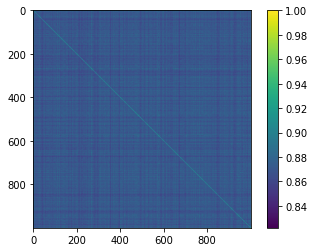

In [112]:
plt.imshow(all_rands)
plt.colorbar()

In [96]:
out

0.8776672398549161

In [89]:


@nb.njit()
def get_rand_index(x, y):
    a=0
    b=0
    c=0
    d=0
    for i in range(len(x)):
        for j in range(len(x)):
            if (x[i]==x[j]) & (y[i]==y[j]):
                a+=1
            elif (x[i]!=x[j]) & (y[i]!=y[j]):
                b+=1
            elif (x[i]!=x[j]) & (y[i]==y[j]):
                c+=1
            elif (x[i]==x[j]) & (y[i]!=y[j]):
                d+=1
    R = (a+b)/(a+b+c+d)
    return R

0.82

In [19]:
n = clusters.shape[1]
consensus = np.empty((n, n))
import numba as nb
@nb.njit()
def get_consensus(n, clusters, consensus):
    for i in range(n):
        for j in range (n):
            consensus[i,j] = np.sum((clusters[:,i]-clusters[:,j])==0)/N

In [22]:
get_consensus(n, clusters, consensus)

In [28]:
x = np.tril(consensus, -1).ravel()

In [51]:
from sklearn.manifold import SpectralEmbedding

In [54]:
embedding = SpectralEmbedding(n_components=1)
X_transformed = embedding.fit_transform(consensus)

/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [58]:
o = np.argsort(X_transformed.ravel())

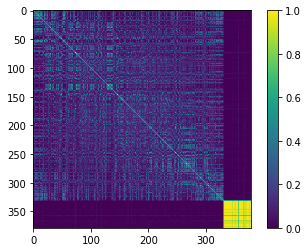

In [62]:
plt.imshow(consensus[o][:,o])
plt.colorbar()

In [ ]:
from sklearn.cluster import SpectralClustering
import numpy as np
X = np.array([[1, 1], [2, 1], [1, 0],
clustering = SpectralClustering(n_clusters=2,
clustering.labels_
clustering

In [40]:
x = np.sum(mat_sub.shape)/50


232735473.2890485

In [43]:
(x**x)*50/((x**(np.sum(mat_sub.shape)-50))*50)

1.8060256985539364e-283

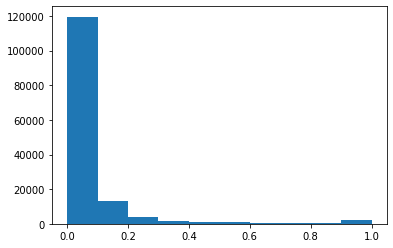

In [36]:
plt.hist(x, 10)
None

#### Assess consistency across runs

In [ ]:
# visualize 

# assign the clusters
from tqdm import tqdm

C = 0
KL_modified = True
random_labels = True
unweighted = True

N=1000
loss = np.empty(N)
clusters = np.empty((N,np.sum(mat_sub.shape)))

for i in tqdm(range(N)):
    frame, loss_temp = get_kernighan_lin_clusters(None, 50, C, KL_modified, random_labels, unweighted, seed=i, no_progress=True, mat=mat_sub)
    frame.columns = ['cluster', 'description', 'is_gene']
    clusters[i] = np.array(frame['cluster'])
    loss[i] = loss_temp
    
@nb.njit(parallel=True)
def compute_jaccard_all_clust(arr1, arr2):
    N = len(np.unique(arr1))
    out = np.empty(shape=(N,N))
    for i in nb.prange(N):
        for j in nb.prange(N):
            i_0 = (arr1==i)#.astype(int)
            j_0 = (arr2==j)#.astype(int)
            out[i,j] = compute_jaccard(i_0, j_0)
    return out

temp = compute_jaccard_all_clust(clusters[5], clusters[1])
T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(T[o][:,o], cmap='viridis')#, vmax=0, vmin=-230)
plt.colorbar()
plt.savefig('./pdf_figures/example1.pdf')

temp = compute_jaccard_all_clust(clusters[10], clusters[11])
T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(T[o][:,o], cmap='viridis')#, vmax=0, vmin=-230)
plt.colorbar()
plt.savefig('./pdf_figures/example2.pdf')

temp = compute_jaccard_all_clust(np.random.permutation(clusters[5]), clusters[1])

T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(T[o][:,o], cmap='viridis', vmax=1, vmin=0)
plt.colorbar()
plt.savefig('./pdf_figures/example1_baseline.pdf')

temp = compute_jaccard_all_clust(np.random.permutation(clusters[10]), clusters[11])

T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(T[o][:,o], cmap='viridis', vmax=1, vmin=0)
plt.colorbar()
plt.savefig('./pdf_figures/example2_baseline.pdf')

In [ ]:
# quantify using existing cluster robustness method

#### show loss by method

In [ ]:
plt.hist(loss, label='kernighan-lin')
plt.ylabel('frequency')
plt.xlabel('loss')
plt.legend()
plt.savefig('./pdf_figures/loss.pdf')